# A step-by-step tutorial on active inference and its application to empirical data

- [Paper](https://www.sciencedirect.com/science/article/pii/S0022249621000973)

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from jax import grad
from jax import numpy as jnp
import copy

In [65]:
eps_ = 1e-16
eps_ = np.exp(-16) #NOTE: in all their script and experiments, they use this epsilon value. It seems too large, but will use for now.

def log(x):
    return np.log(x + eps_)

def softmax(x):
    # stable softmax
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

### Variational Free Energy Approximation

$$ F = \sum_{s \in S} q(s) \ln \frac{q(s)}{p(o, s)} $$

#### Example from Figure 3

In [66]:
prior = np.array([.5, .5]) # prior p(s)

p_o_given_s = np.array([.8, .2]) # likelihood p(o|s)

joint_p_o_s =  p_o_given_s * prior # joint p(o, s)
joint_p_o_s

array([0.4, 0.1])

In [67]:
# Compute the exact posterior

p_o = joint_p_o_s.sum() # marginal likelihood p(o)

p_s_given_o = joint_p_o_s / p_o # posterior p(s|o)
p_s_given_o

array([0.8, 0.2])

Minimizing the variational free energy will approach the true posterior distribution as it the upper bound on the log model evidence.

In [68]:
# Compute the approximate posterior

# set the initial approximate posterior q(s) to be the prior
q_s = prior.copy() # approximate posterior q(s)

F = q_s.dot(np.log(q_s / joint_p_o_s)) # compute the KL divergence between the joint and the approximate posterior
F

0.916290731874155

Free energy can also be computed with the exact posterior distribution to demonstrate that the variational free energy is an upper bound on the log model evidence and minimization of the variational free energy will lead q(s) to approach the true posterior distribution.

$$ F = E_{q(s)} \ln \frac{q(s)}{p(s|o)} - \ln p(o) $$

In [69]:
F = np.asarray(q_s).dot(np.log(q_s / p_s_given_o)) - np.log(p_o)
F

0.9162907318741551

In [70]:
# create a jax version of the free energy
grad_F = grad(lambda q_s: q_s.dot(jnp.log(q_s / joint_p_o_s))) # compute the gradient of the KL divergence with respect to the approximate posterior q(s)

In [71]:
# Run this cell ~ 180 times to converge to the exact posterior
learning_rate = .1
# convert the update log probabilities to probabilities via softmax
q_s = softmax(np.log(q_s) - grad_F(q_s) * learning_rate) # compute the gradient of the KL divergence at the initial approximate posterior
q_s

array([0.534602, 0.465398], dtype=float32)

$$ F = E_{q(s)} [\ln q(s) - \ln p(o,s)] $$

In [72]:
F = q_s.dot(np.log(q_s) - np.log(joint_p_o_s))
F

0.8707187106806568

$$ F = E_{q(s)} [\ln q(s) - \ln p(s)] - E_{q(s)}[\ln p (o|s)] $$

In [73]:
F = q_s.dot(np.log(q_s) - np.log(prior)) - q_s.dot(np.log(p_o_given_s))
F

0.8707187106806569

$$ F = D_{KL} [q(s) || p(s)] - E_{q(s)}[\ln p (o|s)] $$

In [74]:
F = q_s.dot(np.log(q_s / prior)) - q_s.dot(np.log(p_o_given_s))
F

0.8707187031922577

### Figure 5 - Static Perception

In [75]:
D = np.array([.5, .5]) # Prior

A = np.array([
    [.9, .2],
    [.1, .8]
]) # likelihood p(o|s) 

o = np.array([1, 0]) # output

q_s = softmax(np.log(D) + np.log(A.T.dot(o)))
q_s

array([0.81818182, 0.18181818])

## Marginal Message Passing

1. Initialize the values of the approximate posteriors q(s_(?,?) ) 
   for all hidden variables (i.e., all edges) in the graph. 
2. Fix the value of observed variables (here, o_?).
3. Choose an edge (V) corresponding to the hidden variable you want to 
   infer (here, s_(?,?)).
4. Calculate the messages, ?(s_(?,?)), which take on values sent by 
   each factor node connected to V.
5. Pass a message from each connected factor node N to V (often written 
   as ?_(N?V)). 
6. Update the approximate posterior represented by V according to the 
   following rule: q(s_(?,?) )? ? ?(s_(?,?))? ?(s_(?,?)). The arrow 
   notation here indicates messages from two different factors arriving 
   at the same edge. 
    6A. Normalize the product of these messages so that q(s_(?,?) ) 
        corresponds to a proper probability distribution. 
    6B. Use this new q(s_(?,?) ) to update the messages sent by 
        connected factors (i.e., for the next round of message passing).
7. Repeat steps 4-6 sequentially for each edge.
8. Steps 3-7 are then repeated until the difference between updates 
   converges to some acceptably low value (i.e., resulting in stable 
   posterior beliefs for all edges).

from [Message_passing_example.m](https://github.com/rssmith33/Active-Inference-Tutorial-Scripts/blob/main/Message_passing_example.m)




In [76]:
# Example 1

# Fixed observations and message passing steps. Both observations are fixed from the start / already observed. 
# In full active inference there is another time step variable which acts to sequentially present the observations.

# prior p(s) regarding the initial two states
D = np.array([.5, .5])

# likelihood p(o|s) 
A = np.array([
    [.9, .1],
    [.1, .9]
])

# state to state transition probability matrix p(s_ τ+1 |s_ τ)
B = np.array([
    [1, 0],
    [0, 1]
])

# transpose the transition matrices and normalize the columns for future message passing
# Note: this technically not necessary for this example as B.T is already normalized, but it is included for completeness
B_T = [
    b.T / b.T.sum(axis =0) for b in B 
]

# fixed observations o_ τ
# Fix the observations at each time step (Step 2)
o_arr = np.array([
    [1, 0],
    [1, 0]
])

time_steps = len(o_arr) # number of time steps

num_iter = 16 # number of iterations of message passing

# Initialize approximate posteriors q(s) at each time step (Step 1)
qs_arr = np.ones((time_steps, len(D))) / len(D) # array of approximate posteriors q(s) at each time step

# Initialize history of approximate posteriors q(s) for each iteration and time step (This variable is only used for visualization)
qs_history = np.zeros((num_iter, time_steps, len(D)))

# Iterate a set number of times or until convergence (Step 8) 
for i in range(num_iter):
    # For each edge (hidden state) (Step 7)
    for tt in range(time_steps):
        # get the log of the approximate posterior q(s) at this time step (Step 3)
        q_s = np.log(qs_arr[tt])

        # get the message sent from the past (Step 4: Message 1) 
        if tt == 0: # if this is the first time step we use the prior
            log_B_past = np.log(D)
        else: # otherwise we compute the belief of the current state based on the previous state and the transition matrix
            log_B_past = np.log(B @ qs_arr[tt - 1])

        # get the message sent from the future (Step 4: Message 2)
        if tt == time_steps - 1: # if this is the last time step we use a message of zero (no future states)
            log_B_future = 0
        else: # otherwise we compute the belief of the current state based on the future state and the transition matrix
            log_B_future = np.log(B_T @ qs_arr[tt + 1])

        # get the likelihood of the state given the observation (Step 4: Message 3)
        log_Ao = np.log(A.T @ o_arr[tt])

        # Pass messages and update the posterior (Step 5-6)
        # Since all terms are in log space, this is addition instead of
        # multiplication. This corresponds to  equation 16 in the main
        # text (within the softmax)
        q_s = .5 * (log_B_past + log_B_future) + log_Ao

        # normalize the posterior (Step 6A)
        qs_arr[tt] = softmax(q_s)

        qs_history[i, tt] = qs_arr[tt]

qs_arr

array([[0.98780488, 0.01219512],
       [0.98780488, 0.01219512]])

array([[0.98780488, 0.01219512],
       [0.98780488, 0.01219512]])

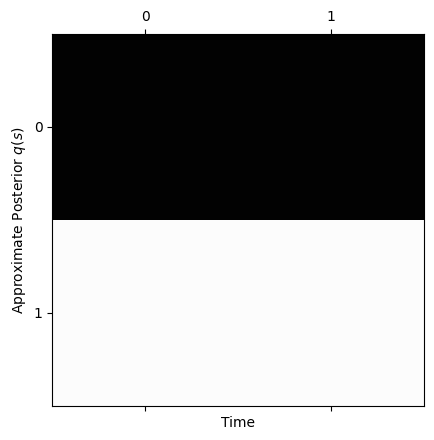

In [77]:
#Example 1: Posterior over states 

plt.matshow(qs_arr.T, vmin = 0.0, vmax = 1.0, cmap='binary')
plt.xlabel('Time')
plt.ylabel('Approximate Posterior $q(s)$')

qs_arr

In [78]:
np.vstack([np.array([[D] * 2]), qs_history]).shape

(17, 2, 2)

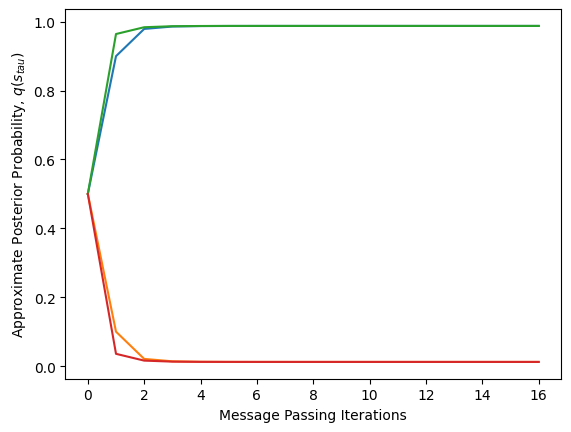

In [79]:
# 
# Note: the initial prior is not always added to the history when plotting
qs_history_with_priors = np.vstack([np.array([[D] * 2]), qs_history])

plt.plot(qs_history_with_priors.reshape(-1, 4))
plt.ylabel('Approximate Posterior Probability, $q(s_{tau})$')
plt.xlabel('Message Passing Iterations')
plt.show()

In [80]:
# Example 2

# prior p(s) regarding the initial two states
D = np.array([.5, .5])

# likelihood p(o|s) 
A = np.array([
    [.9, .1],
    [.1, .9]
])

# state to state transition probability matrix p(s_ τ+1 |s_ τ)
B = np.array([
    [1, 0],
    [0, 1]
])

# transpose the transition matrices and normalize the columns for future message passing
# Note: this technically not necessary for this example as B.T is already normalized, but it is included for completeness
B_T = [
    b.T / b.T.sum(axis =0) for b in B 
]

# In the original Message_passing_example.m code the sequential observations are defined as a matrix; (τ, t)
# this symbolizes that each τ can see all observations up to τ.
# Hence the second observation of the first τ is [0, 0] (not observed)
# o_arr = np.array([
#     [
#         [1, 0],
#         [0, 0]
#     ],
#     [
#         [1, 0],
#         [1, 0]
#     ]
# ])
# For simplicity, we will instead just check in each iteration if τ is less than or equal to t and then use the observation at that time step.
# Otherwise, we will set log_Ao to zero.

# fixed observations o_ τ
# Fix the observations at each time step (Step 2)
o_arr = np.array([
    [1, 0],
    [1, 0]
])

time_steps = len(o_arr) # number of time steps

num_iter = 16 # number of iterations of message passing

# Initialize approximate posteriors q(s) at each time step (Step 1)

qs_arr = np.ones((time_steps, len(D))) / len(D) # array of approximate posteriors q(s) at each time step

# Initialize history of approximate posteriors q(s) for each iteration and time step (This variable is only used for visualization)
qs_history = np.zeros((time_steps, num_iter, time_steps, len(D))) 
# Initialize history of errors for each iteration and time step (This variable is only used for visualization)
err_history = np.zeros((time_steps, num_iter, time_steps, len(D))) 

# for each time step (over all observations)
for t in range(time_steps):
    # for each factor (light blue shapes, light green shapes)
    for i in range(num_iter):
        # for each time step (over all observations)
        for tt in range(time_steps):

            # get the log of the approximate posterior q(s) at this time step (Step 3)
            v = log(qs_arr[tt])

            # get the message sent from the past (Step 4: Message 1) 
            if tt == 0: # if this is the first time step we use the prior
                log_B_past = log(D)
            else: # otherwise we compute the belief of the current state based on the previous state and the transition matrix
                log_B_past = log(B @ qs_arr[tt - 1])

            # get the message sent from the future (Step 4: Message 2)
            if tt == time_steps - 1: # if this is the last time step we use a message of zero (no future states)
                log_B_future = 0
            else: # otherwise we compute the belief of the current state based on the future state and the transition matrix
                log_B_future = log(B_T @ qs_arr[tt + 1])

            # get the likelihood of the state given the observation (Step 4: Message 3)
            if tt <= t: # if the observation has been observed
                log_Ao = log(A.T  @ o_arr[tt] )
            else: # if the observation has not been observed
                log_Ao = 0
    
            err = 0.5 * (log_B_past + log_B_future) + log_Ao - v

            v += err

            qs_arr[tt] = softmax(v)

            err_history[t, i, tt] = err
            qs_history[t, i, tt] = qs_arr[tt]


Text(0, 0.5, 'Approximate Posterior $q(s)$')

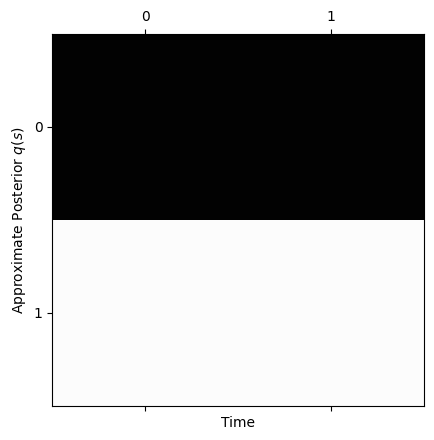

In [81]:
#Example 2: Posterior over states 

plt.matshow(qs_arr.T, vmin = 0.0, vmax = 1.0, cmap='binary')
plt.xlabel('Time')
plt.ylabel('Approximate Posterior $q(s)$')

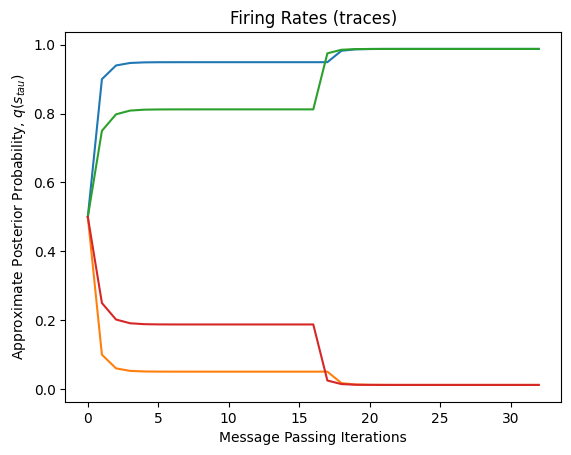

In [82]:
# Note: the initial prior is not always added to the history when plotting
full_beliefs = []
full_beliefs.append(np.array([D] * 2).flatten())
for t in range(time_steps):
    for i in range(num_iter):
        full_beliefs.append(qs_history[t][i].flatten())
full_beliefs = np.asarray(full_beliefs)
plt.plot(full_beliefs)

plt.ylabel('Approximate Posterior Probability, $q(s_{tau})$')
plt.xlabel('Message Passing Iterations')
plt.title("Firing Rates (traces)")
plt.show()

In [83]:
states = 2
epochs = 2

event_related_potentials = []

for tau in range(4):
    epoch_gradients = []
    for i in range(epochs):
            # since we attach the original prior to the beginning of the array, we need to skip the first element
            start_offset = i * num_iter
            end_offset = i * num_iter + num_iter
            epoch_gradients.append(np.gradient(full_beliefs[1:][start_offset:end_offset, tau]))

    event_related_potentials.append(np.concatenate(epoch_gradients))

event_related_potentials = np.asarray(event_related_potentials)

event_related_potentials = np.hstack((np.zeros((4, 1)), event_related_potentials))

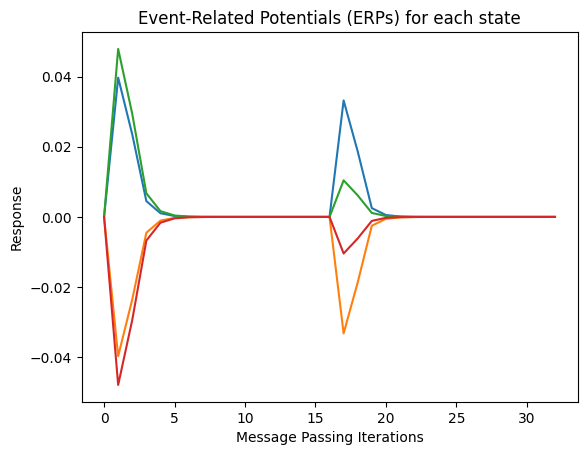

In [84]:
plt.plot(event_related_potentials.T)
plt.xlabel('Message Passing Iterations')
plt.ylabel('Response')
plt.title("Event-Related Potentials (ERPs) for each state")
plt.show()

# State Prediction Errors

επ,τ ←
1(
2
ln Bπ,τ −1 sπ,τ −1 + ln B†π,τ sπ,τ +1
(
− ln sπ,τ
)
(
))
+ ln AT oτ

In [85]:
A = np.array([
    [.8, .4],
    [.2, .6]
])

B_past = np.array([
    [.9, .2],
    [.1, .8]
])

B_current = np.array([
    [.2, .3],
    [.8, .7]
])

# NOTE: in shape_patterns.ipynb the normalization is done via division by the sum of the columns instead of softmax
B_T = softmax(B_current.T)

o = np.array([1, 0])

q_s = np.array([.5, .5])

q_s_past, q_s_future = q_s, q_s

v = log(q_s)

In [86]:
err = 0.5 * (log(B_past @ q_s) + log(B_T @ q_s)) + log(A.T @ o) - v
err

array([-0.17548833, -0.9689707 ])

In [87]:
v = v + err
v

array([-0.86863529, -1.66211765])

In [88]:
q_s = softmax(v)
q_s

array([0.68857857, 0.31142143])

In [89]:
B_past @ q_s_past

array([0.55, 0.45])

In [90]:
softmax(B_current.T)

array([[0.47502081, 0.52497919],
       [0.52497919, 0.47502081]])

## Outcome Prediction Errors

ςπ,τ = Asπ,τ · ln Asπ,τ − ln Cτ − diag AT ln A · sπ,τ

In [91]:
A = np.array([
    [.9, .1],
    [.1, .9]
])

C = np.array([1, 0])

qs_p1 = np.array([.9, .1])

qs_p2 = np.array([.5, .5])

In [92]:
A_qs_p1 = A @ qs_p1
A_qs_p1

array([0.82, 0.18])

In [93]:
A_qs_p1 @ (log(A_qs_p1) - log(C)) # expected difference between preferred outcomes

2.408606645981375

In [94]:
A_q_s_2 = A @ qs_p2
A_q_s_2

array([0.5, 0.5])

In [95]:
A_q_s_2 @ (log(A_q_s_2) - log(C)) # expected difference between preferred outcomes

7.306852988242795

In [96]:
A = np.array([
    [.4, .2],
    [.6, .8]
])

qs_p1 = np.array([.9, .1])
qs_p2 = np.array([.1, .9])

In [97]:
-1 * np.diag(A.T @ log(A)) @ qs_p1

0.6557505175918279

In [98]:
-1 * np.diag(A.T @ log(A)) @ qs_p2

0.5176631228149836

# 3. Building specific task models

#FIXME: copied
In the beginning of the explore–exploit task, the participant
is told that on each trial one machine will tend to pay out more
often, but they will not know which one. They are also told that
the better machine will not always be the same on each trial.
They can choose to select one right away and possibly win $4.
Or they can choose to press a button that gives them a hint about
which slot machine is better on that trial. However, if they choose
to take the hint, they can only win $2 if they pick the correct
machine. Over many trials, the participant can learn which slot
machine tends to pay out more often and either make safe or
risky choices (i.e., take the hint or not).

## Capital letters stand for the generative process and lower case letters stand for the generative model.

In [99]:
# Generative process priors

# context: both machines are equally likely to have the better outcome
D_1 = np.array([.5, .5]) # numbers in paper 
# D_1 = np.array([1, 0]) # numbers in code

# choices:
# 1. start
# 2. hint
# 3. choose left/0
# 4. choose right/1
D_2 = np.array([1, 0, 0, 0])

D = [D_1, D_2]

In [100]:
# Generative model priors

d_1 = np.array([.25, .25])

d_2 = np.array([1, 0, 0, 0])

d = [d_1, d_2]

In [101]:
# A_1 represents the observation likelihoods corresponding to the hint given a state 
# there is a outcome likelihood for each possible choice (start, hint, left, right)
# for each likelihood matrix, the rows correspond to the observations, (no hint, left is better, right is better)
# and the columns correspond to the number of context (left is better, right is better)

phA = 1 # probability of accuracy of the hint

A_1 = np.array([
    # column 1: # left is better
    # column 2: # right is better
    # start
    [
        [1, 1], # no hint
        [0, 0], # left is better
        [0, 0], # right is better
    ],
    # hint
    [
        [0, 0], # no hint
        [phA, 1 - phA], # left is better
        [1 - phA, phA], # right is better
    ],
    # choose left
    [
        [1, 1], # no hint
        [0, 0], # left is better
        [0, 0], # right is better
    ],
    # choose right
    [
        [1, 1], # no hint
        [0, 0], # left is better
        [0, 0], # right is better
    ],
])

# A_1 may be converted to this form for easier indexing

# column 1: start
# column 2: hint
# column 3: choose left
# column 4: choose right

A_1 = np.array([
    # left is better
    [
        [1, 0,     1, 1], # no hint
        [0, phA,   0, 0], # hint left is better
        [0, 1-phA, 0, 0]  # hint right is better
    ],
    # right is better
    [
        [1, 0,     1, 1], # no hint
        [0, 1-phA, 0, 0], # left is better
        [0, phA,   0, 0]  # right is better
    ]
])

'''
may have to be converted to this?

# column 1: no hint
# column 2: hint left is better
# column 3: hint right is better


A_1 = np.array([
    # left is better

    [
        [1, 0 , 0],      # start
        [0, phA, 1-phA], # hint
        [1, 0, 0],       # choose left
        [1, 0, 0]        # choose right
    ],
    # right is better
    [
        [1, 0 , 0],      # start
        [0, 1-phA, phA], # hint
        [1, 0, 0],       # choose left
        [1, 0, 0]        # choose right
    ]
])
'''

# A_2 represents the observation likelihoods corresponding to the win/lose outcomes given a state
# there is a outcome likelihood for each possible choice (start, hint, left, right)
# for each likelihood matrix, the rows correspond to the observations, (undetermined, win, loss)
# and the columns correspond to the number of context (left is better, right is better)

pWin = .8 # probability of winning

A_2 = np.array([
    # start
    [
        [1, 1], # undetermined
        [0, 0], # loss
        [0, 0], # win
    ],
    # hint
    [
        [1, 1], # undetermined
        [0, 0], # loss
        [0, 0], # win
    ],
    # choose left
    [
        [0, 0], # undetermined
        [1 - pWin, pWin], # loss
        [pWin, 1 - pWin], # win
    ],
    # choose right
    [
        [0, 0], # undetermined
        [pWin, 1 - pWin], # loss
        [1 - pWin, pWin], # win
    ],
])

# A_2 may be converted to this form for easier indexing

# column 1: start
# column 2: hint
# column 3: choose left
# column 4: choose right

A_2 = np.array([
    # left is better
    [
        [1. , 1. , 0.  ,0. ], # undetermined
        [0. , 0. , pWin, 1 - pWin], # win
        [0. , 0. , 1 - pWin, pWin]  # loss
    ],
    # right is better
    [
        [1. , 1. , 0.  ,0. ], # undetermined
        [0. , 0. , 1 - pWin, pWin], # win
        [0. , 0. , pWin, 1 - pWin]  # loss
    ]
])

'''
A_2 may be converted to this form for easier indexing


# column 1: undetermined
# column 2: win
# column 3: loss

A_2 = np.array([
    # left is better
    [
        [1, 0, 0], # start
        [1, 0, 0], # hint
        [0, pWin, 1 - pWin], # choose left
        [0, 1 - pWin, pWin], # choose right
    ],
    # right is better
    [
        [1, 0, 0], # start
        [1, 0, 0], # hint
        [0, 1 - pWin, pWin], # choose left
        [0, pWin, 1 - pWin], # choose right
    ],
])
'''


# A_3 represents the mapping between the behavior states and observed behaviors

A_3 = np.array([
    [
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
    ],
    [
        [0, 0],
        [1, 1],
        [0, 0],
        [0, 0],
    ],
    [
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
    ],
    [
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
    ],
])

# A_3 may be converted to this form for easier indexing

# column 1: start
# column 2: hint
# column 3: choose left
# column 4: choose right

A_3 = np.array([
    # left is better
    [
        [1, 0, 0, 0], # start
        [0, 1, 0, 0], # hint
        [0, 0, 1, 0], # choose left
        [0, 0, 0, 1], # choose right
    ],
    # right is better
    [
        [1, 0, 0, 0], # start
        [0, 1, 0, 0], # hint
        [0, 0, 1, 0], # choose left
        [0, 0, 0, 1], # choose right
    ],
])

'''
A_3 may be converted to this form for easier indexing

# column 1: start
# column 2: hint
# column 3: choose left
# column 4: choose right

A_3 = np.array([
    # left is better
    [
        [1, 0, 0, 0], # start
        [0, 1, 0, 0], # hint
        [0, 0, 1, 0], # choose left
        [0, 0, 0, 1], # choose right
    ],
    # right is better
    [
        [1, 0, 0, 0], # start
        [0, 1, 0, 0], # hint
        [0, 0, 1, 0], # choose left
        [0, 0, 0, 1], # choose right
    ],
])
'''


A = [A_1, A_2, A_3]

In [102]:
from functools import reduce

reduce(lambda x, y: x.T @ y, D, A_1)

array([1., 0., 0.])

In [103]:
tA_1 = np.array([
    # left is better

    [
        [1, 0 , 0],      # start
        [0, phA, 1-phA], # hint
        [1, 0, 0],       # choose left
        [1, 0, 0]        # choose right
    ],
    # right is better
    [
        [1, 0 , 0],      # start
        [0, 1-phA, phA], # hint
        [1, 0, 0],       # choose left
        [1, 0, 0]        # choose right
    ]
])

tA_2 = np.array([
    # left is better
    [
        [1, 0, 0], # start
        [1, 0, 0], # hint
        [0, pWin, 1 - pWin], # choose left
        [0, 1 - pWin, pWin], # choose right
    ],
    # right is better
    [
        [1, 0, 0], # start
        [1, 0, 0], # hint
        [0, 1 - pWin, pWin], # choose left
        [0, pWin, 1 - pWin], # choose right
    ],
])

tA_3 = np.array([
    # left is better
    [
        [1, 0, 0, 0], # start
        [0, 1, 0, 0], # hint
        [0, 0, 1, 0], # choose left
        [0, 0, 0, 1], # choose right
    ],
    # right is better
    [
        [1, 0, 0, 0], # start
        [0, 1, 0, 0], # hint
        [0, 0, 1, 0], # choose left
        [0, 0, 0, 1], # choose right
    ],
])

tA = [tA_1, tA_2, tA_3]

In [104]:
t_1 = tA_1 @ np.array([1, 0, 0])
t_1

array([[1, 0, 1, 1],
       [1, 0, 1, 1]])

In [105]:
t_1 @ np.array([1, 0, 0, 0])

array([1, 1])

In [106]:
np.tensordot(tA_1, np.array([1, 0, 0]), axes=1)

array([[1, 0, 1, 1],
       [1, 0, 1, 1]])

In [107]:
tA_2

array([[[1. , 0. , 0. ],
        [1. , 0. , 0. ],
        [0. , 0.8, 0.2],
        [0. , 0.2, 0.8]],

       [[1. , 0. , 0. ],
        [1. , 0. , 0. ],
        [0. , 0.2, 0.8],
        [0. , 0.8, 0.2]]])

In [108]:
t_2 = tA_2 @ np.array([1, 0, 0])
t_2

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [109]:
t_2 @ np.array([0, 0, 1, 0])

array([0., 0.])

In [110]:
t_3 = tA_3 @ np.array([1, 0, 0, 0])
t_3

array([[1, 0, 0, 0],
       [1, 0, 0, 0]])

In [111]:
dim = (1)
(t_1 * t_2 * t_3).sum(axis=dim) / (t_1 * t_2 * t_3 + 1e-16).sum(axis=dim)

array([1., 1.])

In [112]:
# B_1 represents the transition probabilities between the context states. Since the agent can not change the context, the transition matrix is the identity matrix

B_1 = np.array([
    [1, 0], # left is better
    [0, 1], # right is better
])

# Note: technically only one matrix is required but to make python operations easier, we will use two matrices
B_1 = np.array([
    [
        [1, 0], # left is better
        [0, 1], # right is better
    ],
    [
        [1, 0], # left is better
        [0, 1], # right is better
    ],
])

# B_1 may be converted to this form for easier indexing

# B_1 = np.array([
#     [
#         [1, 0], # left is better
#     ],
#     [
#         [0, 1], # right is better
#     ],
# ])
    

B_2 = np.array([
    # move to the start state from any other state
    [
        [1, 1, 1, 1], # start
        [0, 0, 0, 0], # hint
        [0, 0, 0, 0], # choose left
        [0, 0, 0, 0], # choose right
    ],
    # move to the hint state from any other state
    [
        [0, 0, 0, 0], # start
        [1, 1, 1, 1], # hint
        [0, 0, 0, 0], # choose left
        [0, 0, 0, 0], # choose right
    ],
    # move to the choose left state from any other state
    [
        [0, 0, 0, 0], # start
        [0, 0, 0, 0], # hint
        [1, 1, 1, 1], # choose left
        [0, 0, 0, 0], # choose right
    ],
    # move to the choose right state from any other state
    [
        [0, 0, 0, 0], # start
        [0, 0, 0, 0], # hint
        [0, 0, 0, 0], # choose left
        [1, 1, 1, 1], # choose right
    ],
])

# B_2 may be converted to this form for easier indexing

# B_2 = np.array([
#     # left is better
#     [
#         [1, 0, 0, 0], # start
#         [0, 1, 0, 0], # hint
#         [0, 0, 1, 0], # choose left
#         [0, 0, 0, 1], # choose right
#     ],
#     # right is better
#     [
#         [1, 0, 0, 0], # start
#         [0, 1, 0, 0], # hint
#         [0, 0, 1, 0], # choose left
#         [0, 0, 0, 1], # choose right
#     ],
# ])

# B_2 = np.array(
#     [
#         [1, 1, 1, 1],
#         [1, 1, 1, 1],
#         [1, 1, 1, 1],
#         [1, 1, 1, 1]
#     ]
# )

# B_2 = np.ones((4, 4)) / 4

B = [B_1, B_2]

# B_1.T / B_1.T.sum(axis =0)
# B_future = [b.T / b.T.sum(axis =-1, keepdims=True) for b in B]
B_future = [b.sum(axis = 0).T / b.sum(axis = 0).T.sum(axis = 0) for b in B]
# B_2_f = 

In [113]:
B_future

[array([[1., 0.],
        [0., 1.]]),
 array([[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]])]

In [114]:
B_2.T / B_2.T.sum(axis =0)

/tmp/ipykernel_13425/4004493251.py:1: RuntimeWarning: invalid value encountered in divide
  B_2.T / B_2.T.sum(axis =0)


array([[[0.25,  nan,  nan,  nan],
        [ nan, 0.25,  nan,  nan],
        [ nan,  nan, 0.25,  nan],
        [ nan,  nan,  nan, 0.25]],

       [[0.25,  nan,  nan,  nan],
        [ nan, 0.25,  nan,  nan],
        [ nan,  nan, 0.25,  nan],
        [ nan,  nan,  nan, 0.25]],

       [[0.25,  nan,  nan,  nan],
        [ nan, 0.25,  nan,  nan],
        [ nan,  nan, 0.25,  nan],
        [ nan,  nan,  nan, 0.25]],

       [[0.25,  nan,  nan,  nan],
        [ nan, 0.25,  nan,  nan],
        [ nan,  nan, 0.25,  nan],
        [ nan,  nan,  nan, 0.25]]])

In [115]:
B_1.T / B_1.T.sum(axis =0)

array([[[1., 1.],
        [0., 0.]],

       [[0., 0.],
        [1., 1.]]])

In [116]:
# B_1 = np.array([
#     [
#         [1, 0], # left is better
#         [0, 1], # right is better
#     ],
#     [
#         [1, 0], # left is better
#         [0, 1], # right is better
#     ],
# ])

# B_1.sum(axis = 0).T / B_1.sum(axis = 0).T.sum(axis = 0)

In [117]:
B_2.sum(axis = 0).T / B_2.sum(axis = 0).T.sum(axis = 0)

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [118]:
np.array([[1., 1., 1., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]) @ np.array([1.00000000e+00, 8.27037108e-18, 8.27037108e-18, 8.27037108e-18])

array([1., 0., 0., 0.])

In [119]:
B_future

[array([[1., 0.],
        [0., 1.]]),
 array([[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]])]

In [120]:
B_2.sum(axis = 0).T / B_2.sum(axis = 0).T.sum(axis = 0)

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [121]:
B_1.sum(axis = 1).T / B_1.sum(axis = 1).T.sum(axis = 0)

array([[0.5, 0.5],
       [0.5, 0.5]])

In [122]:

# rows are observations, columns indicate time points

# no preference for observing a hint or not

C_1 = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

# Preference for observing a win and not a loss

C_2 = np.array([
    [0, 0, 0],
    [0, -1, -1],
    [0, 4, 2]
])

# no preference for observing any action

C_3 = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
])

C = [C_1, C_2, C_3]

In [123]:
log(softmax(C_2))

array([[-1.09861195, -4.02473859, -2.16984503],
       [-1.09861195, -5.02472777, -3.16984334],
       [-1.09861195, -0.02474477, -0.16984589]])

In [124]:
# allowable policies

U = np.array([
    [
        [0, 0],
        [0, 1],
        [0, 2],
        [0, 3]
    ]
])

In [125]:
# rows correspond to time points, columns correspond to context states

V = np.array([
    [
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 2],
        [0, 3]
    ],
    [
        [0, 0],
        [0, 2],
        [0, 3],
        [0, 0],
        [0, 0]
    ]
])

V = np.array([
    
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ],
    # column 1: stay in the start state on the first and second time points
    # column 2: move to the hint state on the first and to the left state on the second time point
    # column 3: move to the hint state on the first and to the right state on the second time point
    # column 4: move to the left state on the first and to the start state on the second time point
    # column 5: move to the right state on the first and to the start state on the second time point
    [
        [0, 1, 1, 2, 3],
        [0, 2, 3, 0, 0]
    ]
])

In [126]:
eta = 0.5 # learning rate
omega = 1 # forgetting rate
beta = 1 # expected precision of expected free energy (G) over policies. (a positive value, with higher values indicating lower expected precision).
alpha = 32 # An 'inverse temperature' or 'action precision' parameter that controls how much randomness there is when selecting actions
erp = 1 # degree of belief resetting at each time point in a trial when simulating neural responses
tau = 12 # time constant for evidence accumulation.
zeta = 3 # Occam window policies

In [136]:
# in this function they use a smaller epsilon value for the log function
def d_softmax(x, axis = 0):
    # stable softmax
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def spm_log(x):
    return np.log(x + 1e-16)

def multi_dot(a, b, dim):
    if dim == 0:
        return np.sum(a @ b[1].reshape(-1, 1), axis = 1)
    elif dim == 1:
        return np.sum(a * b[0].reshape(-1, 1), axis = 0)# np.sum(a @ b[0].reshape(-1, 1), axis = dim)
    raise ValueError("dim must be 0 or 1")

def multi_dot_no_dim(a, b):
    _X = copy.deepcopy(a)
    DIM = np.arange(len(b)) + _X.ndim - len(b)

    for i in range(len(b)):
        # print(i)
        s = np.ones(_X.ndim)
        s[DIM[i]] = len(b[i])
        _X = (_X * b[i].reshape(s.astype(int)))
        
        _X = _X.sum(axis = i + 1, keepdims = True)

    return _X.squeeze()

def sum_probs(prob_array):
    # FIXME: further understand this fn. normalisation of a probability transition matrix (columns)
    s = prob_array + 1e-16
    s = (1 / np.sum(s, axis=0) - 1/ s) / 2
    return s

def normalize(x):
    x = x / x.sum(axis = 0)
    x[np.isnan(x)] = 1/x.shape[0]
    return x

# MDP_VB_X_TUTORIAL defined & initialized
T = 3

s = np.zeros((2, 3), dtype=int)
o = np.zeros((3, 3))
n = np.zeros((3, 3))

# outside variables
# state_sizes = [2, 4]
state_sizes = [len(d) for d in D]
Nu = 4#[1, 4]
Np = 5
No = [3, 3, 4]
Ni = 16
Ng = 3 # number of outcome factors
Nf = 2
M = [1, 1, 1]
S = 3
policies = np.arange(Np) #5


#FIXME: can be replaced with capital U?
# u = np.zeros((T, 1))
u = []

F_hist = np.zeros((T, Np))
Q_hist = np.zeros((T, Np))
H_hist = np.zeros(T)

qE = spm_log(np.ones(5) / 5)

qb = beta # rate parameters
w = np.array([1/qb] * T) # posterior precision (policy)

pD = copy.deepcopy(d)
wD = [sum_probs(_d) for _d in d]

# X = copy.deepcopy(D) # TODO: maybe have to be expanded by time points

X = [np.zeros((T, *_d.shape)) for _d in D]
for i, _d in enumerate(D):
    X[i][0] = _d

x = [np.ones((ns, T, Np)) / ns for ns in state_sizes]

P = np.zeros((T, Nu))


for k in range(Np):
    for f in range(Nf):
        x[f][:, 0, k] = D[f]

xn = [np.zeros((Ni, ns, S, T, Np)) + 1/ns for ns in state_sizes]
vn = [np.zeros((Ni, ns, S, T, Np)) for ns in state_sizes]

wn = np.zeros(T * Ni)
un = np.zeros((T * Ni, Np))
ext_u = np.zeros((T, Np))

ext_A = []
for g in range(Ng):
    ext_A.append(normalize(np.transpose(A[g], axes=(1, 2, 0))))

ext_C = [spm_log(softmax(c)) for c in C] 
# transition probabilities



# variables initialized and used in the loop
xqq = [np.zeros_like(_d) for _d in D]
xq = [np.zeros_like(_d) for _d in D]

# may have to be expanded to fit factors
L = np.ones((T, 2, 4))


np.random.seed(42)

outs = [
    #np.zeros((T, a.shape[-1])) for a in A
    [] for _ in range(Ng)
]

qs_arr = [
    np.ones((T, Np, len(d))) / len(d) for d in D
]

qs_history_arr = [
    np.ones((T, S, Ni, Np, state_size)) for state_size in state_sizes
]

for k in range(Np):
    for f in range(Nf):
        qs_arr[f][0][k] = D[f]
# for f in range(Nf):
        # x[f][:, 0, k] = D[f]

# belief updating over successive time points
for t in range(T):

    # generative process 

    # sample state, if not specified
    for f in range(Nf):

        if s[f, t] == 0:
    
            if t > 0:
                #TODO: check if out put is correct
                ps = B[f][u[t -1][f]][:,int(s[f, t - 1])] #B[f][int(s[f, t - 1])][u[t -1][f]]
            else:
                
                ps = D[f] / D[f].sum() # ensure ps is normalized
            # sample state
            s[f, t] = np.argmax(np.random.rand() < np.cumsum(ps)) # FIXME: check if argmax is correct

    # posterior predictive density over hidden (external) states
        # Bayesian model average (xq)
        xq[f] = X[f][t]

    # sample outcome given the current state if not specified
    for g in range(Ng):
        # if outcome not specified
        if len(outs[g]) <= t:
            # sample outcome

            if n[g, t]: # outcome is generated by model n if not 0
                pass
            else: # or sampled from likelihood given hidden states
                #fs_1_index, fs_2_index = s[:, t] #FIXME: has to be generalized
                # po = A[g][int(ind[0]), :, int(ind[1])]

                factor_state_indices = s[:, t] 
                po = tA[g][*factor_state_indices]
                # po = A[g][fs_1_index, :, fs_2_index]
                o_index = np.argmax(np.random.rand() < np.cumsum(po))
                os = np.zeros(No[g])
                os[o_index] = 1
                
                outs[g].append(os)
            

    # eliminate unlikely policies
    if len(u) - 1 < t  and t > 0: # TODO: len u has to be changed (should check if U is defined)
        F = np.log(ext_u[t - 1]) 
        policies = policies[(F - np.max(F)) > -zeta]

    # processing time and reset
    # for f in range(Nf):
    #     x[f] = softmax(spm_log(x[f]) / erp)

    for f in range(Nf):
        qs_arr[f] = d_softmax(spm_log(qs_arr[f]) / erp, axis = -1)


    S = V.shape[0] + 1 # horizon

    R = S

    F = np.zeros(Np)
    for k in policies: # loop over plausible policies
        dF = 1 # reset criterion for this policy
        for i in range(Ni): # iterate belief updates
            F[k] = 0  # reset free energy for this policy
            for tt in range(S): # loop over future time points
                # current posterior over outcome factors
                if tt <= t:
                    for f in range(Nf):
                        xq[f] = qs_arr[f][tt][k]# x[f][:, tt, k]

                    tt_outs = [o[tt] for o in outs]

                    sp_o = np.prod([a @ o for a, o in zip(tA, tt_outs)], axis = 0)
                    

                for f in range(Nf):
                    # hidden states for this time and policy
                    sx = qs_arr[f][tt][k]#x[f][:, tt, k]
                    v = np.zeros(state_sizes[f])

                    # evaluate free energy and gradients
                    if dF > np.exp(-8) or i > 3: # early stopping criterion for gradient descent
                        # marginal likelihood over outcome factors
                        if tt <= t:
                            reduce_dims = tuple(fi for fi in list(range(Nf)) if fi != f)
                            # _qx = reduce(lambda x, y: (x[..., np.newaxis] * y), xq)#.sum(axis=f)
                            # qL = reduce(lambda x, y: (x * y).sum(axis = reduce_dims), [xq[i] for i in reduce_dims], sp_o )
                            # qL = (_qx *sp_o).sum(axis=reduce_dims) / (sp_o + 1e-16).sum(axis=reduce_dims)
                            qL = sp_o.sum(axis=reduce_dims) / (sp_o + 1e-16).sum(axis=reduce_dims)
                            qL = spm_log(qL)
                        else:
                            qL = 0

                        # entropy
                        qx = spm_log(sx) # FIXME: qx values are not the same as in the matlab code

                        # empirical priors (forward messages)
                        if tt == 0:
                            log_B_past = spm_log(D[f])
                        else:
                            log_B_past = spm_log(B[f][V[f, tt - 1, k]] @ qs_arr[f][tt - 1][k])
                        v = v + log_B_past + qL - qx # FIXME: adding to v incrementally to stay closer to the matlab code (precision changes slightly)


                        if tt == T - 1:
                            log_B_future = 0
                        else:
                            log_B_future = spm_log(B_future[f].T @ qs_arr[f][tt + 1][k])
                        v = v + log_B_future + qL - qx # FIXME: adding to v incrementally to stay closer to the matlab code (precision changes slightly)

                        # v = ((log_B_past + log_B_future) + 2*(qL - qx))#(0.5 * (log_B_past + log_B_future) + qL - qx) # TODO: for some reason they do ((log_B_past + log_B_future) + 2*(qL - qx))

                        if tt == 0 or tt == S - 1:
                            F[k] = F[k] + np.dot(sx.T, v * 0.5) # remove the 0.5 when going back to (0.5 * (log_B_past + log_B_future) + qL - qx)
                        else:
                            F[k] = F[k] + np.dot(sx.T, v * 0.5 - (Nf - 1) * qL / Nf)

                        v -= np.mean(v) # TODO: this line shouldn't be necessary
                        # v = 2*v - np.mean(2 * v) # TODO: this line shouldn't be necessary

                        sx = softmax(qx + v / tau)
                    else:
                        v = np.zeros(state_sizes[f])
                        F[k] = G[k]

                    qs_arr[f][tt][k] = sx
                    qs_history_arr[f][t, tt, i, k] = sx
                    xq[f] = sx
                    # xn[f][i, :, tt, t, k] = sx
                    # vn[f][i, :, tt, t, k] = v

            if i > 0:
                dF = F[k] - G[k]
            
            G = F.copy()

    # accumulate expected free energy over policies (Q)
    pu = 1 # empirical prior
    qu = 1 # posterior
    Q = np.zeros(Np) # expected free energy over policies

    if Np > 0: #FIXME: check if this should be 1
        for k in policies:
            # bayesian surprise about initial conditions
            for f in range(Nf):
                Q[k] = Q[k] - wD[f] @ qs_arr[f][0][k] # FIXME: should be spm_dot

            pass
            # iterate over current and future time points
            for tt in range(t, S):
                # get expected states for this policy and time point
                for f in range(Nf): # TODO: check if required
                    xq[f] = qs_arr[f][tt][k]

                # g_G = []
                # ln_o_arr = []
                # pu_arr = []
                G = 0
                for g in range(Ng):
                    #  Bayesian surprise about outcomes
                    # we have to define qo again because in the spm_MDP
                    qo = reduce(lambda x, y: y @ x, xq[::-1], tA[g])
                    ln_o = qo @ np.log(qo + 1e-16)

                    H_A = (tA[g] * np.log(tA[g] + 1e-16)).sum(axis = -1)
                    pu = reduce(lambda x, y: y @ x, xq, H_A)

                    G += pu - ln_o

                Q[k] += G

                pass

                for g in range(Ng):
                    # prior preferences over outcomes
                    qo = reduce(lambda x, y: y @ x, xq[::-1], tA[g])
                    Q[k] += qo @ spm_log(softmax(C[g][:,tt]))

                pass

    # previous expected precision
    if t > 0:
        w[t] = w[t - 1]

    for i in range(Ni):
        #posterior and prior beliefs about policies
        qu = softmax(qE[policies] + w[t] * Q[policies] + F[policies])
        pu = softmax(qE[policies] + w[t] * Q[policies])

        # precision (w) with free energy gradients (v = -dF/dw)
        eg = (qu - pu) @ Q[policies]
        dFdg = qb - beta + eg
        qb = qb - dFdg / 2
        w[t] = 1/qb

        # simulated dopamine responses (expected precision)
        _n = t * Ni + i #TODO: originally was t - 1
        wn[_n] = w[t]
        un[_n][policies] = qu
        ext_u[t][policies] = qu


    # bayesian model averaging (over policies)
    for f in range(Nf):
        for tt in range(S):
            X[f][tt] =  ext_u[t] @ qs_arr[f][tt] #FIXME: might be cause for troubles

    
    # processing (reaction) time
    F_hist[t] = F
    Q_hist[t] = Q
    H_hist[t] = qu @ F[policies] - qu @ (spm_log(qu) - spm_log(pu))


    if t < T -1:

        Pu = np.zeros(Nu)

        for k in range(Np):
            Pu[V[1, t, k]] += ext_u[t][k] # still tiny differences in outcome

        Pu = softmax(spm_log(Pu) * alpha)
        P[t] = Pu

        if len(u) > t: # TODO: maybe should be filled with nan instead?
            u[t] = u[t] # unecessary assignment
        else:
            idx = np.argmax(np.random.rand() < np.cumsum(Pu))
            u.append(np.unravel_index(idx, [1, Nu]))

        pass

    #TODO: There's code to check if U is used
            
# if t == T:
#     if T == 1:
#         u = np.zeros((T, 1))
#         o = None
#         s = None
#         u = None





In [138]:
from scipy import special

def betaln(x):
    # only compute the gammaln for elements greater than 0
    x = x[x > 0]
    return special.gammaln(x).sum() - special.gammaln(x.sum())

def psi(x):
    return special.psi(x) - special.psi(x.sum())

pD = copy.deepcopy(d)
# learning - accumulate concentration parameters
# X is different 
# initial hidden states
for f in range(Nf):
    i = d[f] > 0
    # d[f][i] = d[f][i] * omega + X[f][0, i] * eta # TODO: (seems like correct output [(1.0000e+00, 1.2525e-08), (1)])
    d[f] = (d[f] * omega + X[f][0] * eta) * i # TODO: (seems like correct output [(1.0000e+00, 1.2525e-08), (1)])

Fd = np.zeros(Nf)
# (negative) free energy of parameters: state specific
# compute KL divergence between two dirichlet distributions
for f in range(Nf):
    Fd[f] = - ( betaln(pD[f]) - betaln(d[f]) - np.sum((pD[f] - d[f]) * psi(d[f] + 1/32))) 
    # 0.2473
    # -0.04099317344047182

# simulated dopamine (or cholinergic) responses
# wn is different
if Np > 1:
    dn = 8 * np.gradient(wn) + wn / 8 

# Bayesian model averaging of expected hidden states over policies
Xn_arr = []
Vn_arr = []
for f in range(Nf):
    Xn = np.zeros((Ni, state_sizes[f], T, T))
    Vn = np.zeros((Ni, state_sizes[f], T, T))

    for t in range(T):
        for k in range(Np):
            Xn[:, :, :, t] = Xn[:, :, :, t] + np.transpose(qs_history_arr[f][t,:,:,k], (1, 2, 0)) * ext_u[t, k]
            Vn[:, :, :, t] = Vn[:, :, :, t] + vn[f][:, :, :, t, k] * ext_u[t, k]

    Xn_arr.append(Xn)
    Vn_arr.append(Vn)

# number of belief updates (T)
# number of outcomes (O)
# probability of action at time point (P)
# conditional expectations over policies ((ext_)u) -> R
# conditional expectations over N states (x -> Q)
# Bayesian model averages over T outcomes (X)
# utility (C)
# posterior expectations of precision (policy) (w)
# simulated neuronal prediction error (Vn)
# simulated neuronal encoding of hidden states (Xn)
# simulated neuronal encoding of policies (un)
# simulated neuronal encoding of precision (wn)
# simulated dopamine responses (deconvolved) (dn)
# simulated reaction time (seconds) (rt)
pass

In [139]:
Xn_arr

[array([[[[5.00000000e-01, 5.00000000e-01, 9.99999894e-01],
          [5.00000000e-01, 9.97850197e-01, 1.00000000e+00],
          [5.00000000e-01, 6.25201530e-01, 9.99999931e-01]],
 
         [[5.00000000e-01, 5.00000000e-01, 1.05800290e-07],
          [5.00000000e-01, 2.14980308e-03, 1.25973123e-17],
          [5.00000000e-01, 3.74798470e-01, 6.89049029e-08]]],
 
 
        [[[5.00000000e-01, 6.25201530e-01, 9.99999928e-01],
          [5.00000000e-01, 9.99988140e-01, 1.00000000e+00],
          [5.00000000e-01, 7.97638795e-01, 9.99999950e-01]],
 
         [[5.00000000e-01, 3.74798470e-01, 7.21162369e-08],
          [5.00000000e-01, 1.18595695e-05, 7.09518337e-18],
          [5.00000000e-01, 2.02361205e-01, 5.02368735e-08]]],
 
 
        [[[5.00000000e-01, 7.97638795e-01, 9.99999928e-01],
          [5.00000000e-01, 9.99999865e-01, 1.00000000e+00],
          [5.00000000e-01, 9.21391202e-01, 9.99999950e-01]],
 
         [[5.00000000e-01, 2.02361205e-01, 7.21162369e-08],
          [5.000000

In [140]:
f = 0
# TODO: below should be initialized depending on the chosen factor (f)
n_trials = 1 # Nt
n_time_points = 3 # Ne
n_states = 2 # Nx
n_iterations = 16 # Nb

All = []
for i in range(n_time_points):
    for j in range(n_states):
        All.append((j, i))

Units = All

# trials_z = []
# trials_x = []

zj = np.zeros((n_time_points, len(All), n_iterations))
xj = np.zeros((n_time_points, len(All), n_iterations))

vj = np.zeros((n_time_points, len(All), n_iterations))
uj = np.zeros((n_time_points, len(All), n_iterations))

dj = np.zeros((n_iterations))
for trial in range(n_trials):
    plt_xn = Xn_arr[f]

    # all units
    for index, (j, i) in enumerate(All):
        for k in range(n_time_points):
            zj[k, index] = plt_xn[:, j, i, k]
            xj[k, index] = np.gradient(zj[k, index])

    # selected units
    for index, (j, i) in enumerate(Units):
        for k in range(n_time_points):
            vj[k, index] = plt_xn[:, j, i, k]
            uj[k, index] = np.gradient(vj[k, index])

    # dopamine or changes in precision
    dj = dn

dt = 1/ 64 # time bin (seconds)  
t = np.arange(1, n_trials * n_time_points * n_iterations + 1) * dt # time (seconds)
hz = np.arange(4, 32 + 1) # frequency range 
window_size = 1 / (4 * dt) # window length
window_cycles = hz * (dt * window_size) # number of cycles in window

        

    # for j in 

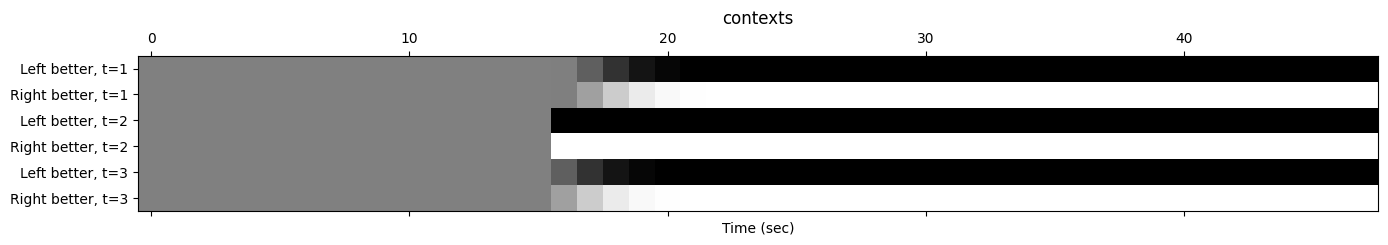

In [141]:
# plot simulated firing rates and local field potentials

plt.matshow(np.concatenate(zj, axis = 1), vmin = 0.0, vmax = 1.0, cmap='binary')
# plt.xticks(range(time_steps))
# set the x ticks to be in range t
plt.xlabel('Time (sec)')
# plt.xlim(0, max(t))
# plt.xticks(t)
# plt.xticks(range(0, n_time_points * n_iterations, n_iterations), t)
# plt.yticks(range(0, len(All)), range(1, len(All) + 1))
contexts = ['Left better', 'Right better']
y_ticks = [f"{contexts[j]}, t={i + 1}" for j, i in All]

plt.yticks(range(0, len(All)), y_ticks)
plt.title('contexts')
plt.axis('equal')
plt.show()

In [ ]:
# time frequency analysis and theta phase

LFP = np.concatenate(xj, axis = 1)

# windowed fourier wavelet transform
(rows, columns) = LFP.shape

# hanning window
_h = 0.5 * (1 - np.cos(2 * np.pi * np.arange(1, window_size + 1) / (window_size + 1)))
_h /= np.sum(_h)
_h

windowed_fourier_transform = np.zeros((len(window_cycles), rows, columns),dtype = 'complex_')

for i in range(len(window_cycles)):
    _W = np.exp(-1j * (2 * np.pi * window_cycles[i] * np.arange(0, columns) / window_size))
    for j in range(rows):
        _w = np.convolve(LFP[j] * _W, _h)
        windowed_fourier_transform[i, j] = _w[(np.arange(columns)+ window_size/2).astype(int)]
# windowed fourier wavelet transform

csd = np.sum(np.abs(windowed_fourier_transform), axis = 1)
lfp = LFP.sum(axis = 0)

# inverse windowed fourier transform - continuos synthesis

# window function (Hanning)
_c = windowed_fourier_transform[0].sum(axis = 0)
n_val = len(_c)
phi = np.zeros(n_val)
conjugate = np.conj(_c)

# spectral density 
for i in range(int(window_cycles[0])):
    _sp = np.exp(-1j * (2 * np.pi * window_cycles[i] * np.arange(n_val)/n_iterations))
    # FIXME: _sp and conjugate seem to match matlab output but _wc does not
    _wc = _sp * conjugate
    phi += np.real(_wc)

lfp = 4 * lfp / np.std(lfp) + 16
phi = 4 * phi / np.std(phi) + 16 
# 


In [ ]:
np.exp(-1j * (2 * np.pi * 1 * np.arange(n_val)/n_iterations)) * conjugate

In [ ]:
conjugate[-1]

In [ ]:
#FIXME: plot looks too different investigate phi
# plt.matshow(csd[::-1], cmap='binary_r')
plt.matshow(csd, cmap='binary_r', aspect='auto', origin='lower')
plt.plot(lfp, color = 'w', linestyle = '--')
plt.plot(phi, color = 'w')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Time frequency response')

plt.show()

In [ ]:
plt.plot(np.concatenate(uj, axis = 1).T)
x_time = np.arange((n_time_points*n_trials)*n_iterations)[::10]
plt.xticks(x_time, (x_time) * dt)
plt.xlabel('Time (sec)')
plt.ylabel('Response')
plt.title('Local field potentials')
plt.show()

In [ ]:
plt.plot(np.concatenate(vj, axis = 1).T)
plt.xlabel('Time (sec)')
plt.ylabel('Response')
plt.title('Firing rates')
plt.show()

In [ ]:
# simulated dopamine responses (if not a moving policy)

dnz = dj * (dj > 0)
plt.bar(np.arange(len(dnz)), dnz + (dnz + 1/16) * np.random.rand(len(dnz)) / 8, color = 'k', width=1)
plt.xlabel('Time (updates)')
plt.ylabel('Change in Precision')
plt.title('Dopamine responses')
plt.show()


In [ ]:
rasters = np.kron(np.concatenate(zj, axis = 1).T, np.ones((n_iterations, n_iterations)))
plt.matshow(~(np.random.rand(*rasters.shape) > (rasters * (1 - 1/16)) ).T, cmap='binary', aspect='auto') # TODO: why invert the values?
plt.xlabel('Time (sec)')
# contexts = ['Left better', 'Right better']
# y_ticks = [f"{contexts[j]}, t={i + 1}" for j, i in All]

# plt.yticks(range(0, len(All)), y_ticks)
plt.title('Unit firing')
plt.show()

In [ ]:
np.arange((n_time_points*n_trials)*n_iterations)[::5]

In [ ]:
0.5 * (1 - 2 * np.pi * np.cos(np.arange(1, window_size + 1) / (window_size + 1)))

In [ ]:
_W = np.exp(-1j * (2 * np.pi * window_cycles[0] * np.arange(0, columns) / window_size))
_W
# np.convolve(LFP[0] * _W, _h, mode='same')

In [ ]:
np.convolve(LFP[0] * _W, _h).shape